## Model experiment

In [254]:
import torch
from torch import nn
from torchvision.models import resnet18

In [2]:
backbone = resnet18(pretrained=True)

In [3]:
test_input = torch.randn(1, 5, 3, 145, 800)

In [41]:
backbone.fc.out_features = 88

In [42]:
block1 = nn.Sequential(
    backbone.conv1,
    backbone.bn1,
    backbone.relu,
    backbone.maxpool,
    backbone.layer1
)

In [43]:
block1_out = [block1(t) for t in test_input.transpose(1, 0)]

In [44]:
agg_input = torch.stack(block1_out, dim=2)

In [45]:
agg_input.shape

torch.Size([1, 64, 5, 37, 200])

In [46]:
agg_module = nn.Conv3d(64, 64, kernel_size=(5, 1, 1), stride=1, padding=(0, 0, 0))

In [47]:
agg_out = agg_module(agg_input)

In [48]:
agg_out.shape

torch.Size([1, 64, 1, 37, 200])

In [49]:
slope_vector = torch.linspace(0, 1, 88)
slope_vector = slope_vector.expand((1,1,-1))

In [50]:
slope_module = nn.Sequential(
    nn.Conv1d(1, 1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv1d(1, 1, kernel_size=3, padding=1),
    nn.ReLU(),
)

# sp_clone = nn.Sequential(
#     nn.Conv2d(1, 64, )
# )

In [51]:
nn.Conv1d(1, 1, kernel_size=3, padding=1, stride=2)(slope_vector).shape

torch.Size([1, 1, 44])

In [52]:
batch_size = 1
slope_vector_out1 = slope_module(slope_vector)
slope_vector_out1 = slope_vector_out1.expand((batch_size, 1, 10, 88))

In [53]:
slope_expand = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=[1, 39], padding=[0, 0]),
    nn.ReLU()
)
slope_vector_out2 = slope_expand(slope_vector_out1)

In [54]:
layer_2and3 = nn.Sequential(
    backbone.layer2,
    backbone.layer3
)

In [55]:
agg_out = torch.squeeze(agg_out, dim=2)

In [56]:
agg_out.shape

torch.Size([1, 64, 37, 200])

In [57]:
layer2_out = layer_2and3(agg_out)

In [58]:
layer2_out.shape

torch.Size([1, 256, 10, 50])

In [59]:
rest_in = torch.cat([layer2_out, slope_vector_out2], dim=1)
slope_conv = nn.Sequential(
    nn.Conv2d(in_channels=320, out_channels=256, kernel_size=3, padding=1),
    nn.ReLU()
)
rest_in = slope_conv(rest_in)

In [60]:
rest_in.shape

torch.Size([1, 256, 10, 50])

In [70]:
layer4 = nn.Sequential(
    backbone.layer4,
    backbone.avgpool,
    nn.Flatten(),
    nn.Linear(in_features=512, out_features=88, bias=True)
)

In [72]:
output = layer4(rest_in)

---------------

## Model Modularize, Dataset

In [1]:
import torch
from torch import nn
from torchvision.models import resnet18

In [135]:
class SightToSound(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.backbone = resnet18(pretrained=True)
        
        self.block1 = nn.Sequential(
            self.backbone.conv1,
            self.backbone.bn1,
            self.backbone.relu,
            self.backbone.maxpool,
            self.backbone.layer1
        )
        
        self.agg_module = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=(5, 1, 1), stride=1, padding=(0, 0, 0)),
            nn.ReLU()
        )
        
        self.slope_vector = torch.linspace(0, 1, 88).to("cuda")
        self.slope_vector = self.slope_vector.expand((1,1,-1))
        
        self.slope_module = nn.Sequential(
            nn.Conv1d(1, 1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(1, 1, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        self.slope_expand = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=[1, 39], padding=[0, 0]),
            nn.ReLU()
        )
        
        self.block_2_3 = nn.Sequential(
            self.backbone.layer2,
            self.backbone.layer3
        )
        
        self.slope_conv = nn.Sequential(
            nn.Conv2d(in_channels=320, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.block4 = nn.Sequential(
            self.backbone.layer4,
            self.backbone.avgpool,
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=88, bias=True)
        )
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = [self.block1(t) for t in x.transpose(1, 0)]
        x = torch.stack(x, dim=2)
        
        x = self.agg_module(x)
        x = torch.squeeze(x, dim=2)
        
        slope_vector = self.slope_module(self.slope_vector)
        slope_vector = slope_vector.expand((batch_size, 1, 10, 88))
        slope_vector = self.slope_expand(slope_vector)
        
        x = self.block_2_3(x)
        
        # x_cat = torch.cat([x, slope_vector], dim=1)
        # x_cat = self.slope_conv(x_cat)
        
        output = self.block4(x)
        
        return output

In [136]:
from torch.utils.data import Dataset, DataLoader
from itertools import accumulate
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import os
import numpy as np
import time
from PIL import Image
from multiprocessing import Process

In [138]:
class PianoYTDataset(Dataset):
    def __init__(self, data_dir, k=5, transforms=None):
        self.data_dir = data_dir
        self.train_image_dir = os.path.join(data_dir, "images/train")
        self.train_label = os.path.join(data_dir, "labels/train")
        
        self.image_dir_names = sorted(os.listdir(self.train_image_dir))
        
        self.image_len_per_dir = [len(os.listdir(os.path.join(self.train_image_dir, image_path))) - (k-1) for image_path in sorted(self.image_dir_names)]
        self.image_maxidx_per_dir = list(accumulate(self.image_len_per_dir))
    
    def __len__(self):
        return self.image_maxidx_per_dir[-1]
    
    def __getitem__(self, idx):
        dir_idx = 0
        image_idx = 0
        
        for i, max_idx in enumerate(self.image_maxidx_per_dir):
            if max_idx > idx:
                dir_idx = i
                image_idx = idx - (self.image_maxidx_per_dir[i-1] if i-1 >= 0 else 0)
                break
                
        target_dir_path = os.path.join(self.train_image_dir, self.image_dir_names[dir_idx])
        target_image_name = [str(i+1).zfill(4) + ".png" for i in range(image_idx, image_idx+5)]

        img_list = []
        for image_path in map(lambda x: os.path.join(target_dir_path, x), target_image_name):
            img = cv2.imread(image_path)
            img = img / 255.0
            img = img.transpose(2, 0, 1)
            img_list.append(img)
        
        img = np.stack(img_list, axis=0)
        img = torch.from_numpy(img).float()
        dir_idx = self.image_dir_names[dir_idx].split("_")[0]
        label_np = np.load(os.path.join(self.train_label, f"{dir_idx}.npy"))
        label = label_np[image_idx+2]

        return img, label

In [139]:
model = SightToSound()

In [140]:
ds = PianoYTDataset("./ytdataset/")

In [141]:
train_loader = DataLoader(ds, batch_size=24, shuffle=True)

In [142]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([10]).cuda())
device = "cuda" if torch.cuda.is_available() else "cpu"

In [188]:
# %load_ext line_profiler

max_epoch = 40

model = model.to(device)
for epoch in range(max_epoch):
    print(f"Epoch {epoch}")
    model.train()
    loss_sum = 0
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)
        
        output = model(img)
        
        loss = criterion(output, label)
        
        loss_sum += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if i!=0 and i%10 == 0:
            print(f"[{i}/{len(train_loader)}] loss : {loss.item()}")
            
        if i!=0 and i%200 == 0:
            print(f"mean loss : {loss_sum / 200.0}")
            break
            
# %lprun -f train train()

Epoch 0
[10/16929] loss : 0.15465301937236206
[20/16929] loss : 0.11326364620014141
[30/16929] loss : 0.08361565601922036
[40/16929] loss : 0.06652640625769224
[50/16929] loss : 0.11060617414134122
[60/16929] loss : 0.06408901881420934
[70/16929] loss : 0.09131105852304802
[80/16929] loss : 0.1176240457383715
[90/16929] loss : 0.05348968349185812
[100/16929] loss : 0.0722897596519831
[110/16929] loss : 0.06114119327824953
[120/16929] loss : 0.10507449929425826
[130/16929] loss : 0.11848714181645119
[140/16929] loss : 0.03549977722119889
[150/16929] loss : 0.033126734923340805
[160/16929] loss : 0.0953826851073656
[170/16929] loss : 0.06743947463631723
[180/16929] loss : 0.08300217812966379
[190/16929] loss : 0.11931383751750187
[200/16929] loss : 0.10320961331763356
mean loss : 0.0823794533941169
Epoch 1
[10/16929] loss : 0.11039166099063348
[20/16929] loss : 0.07566477018696327
[30/16929] loss : 0.07080909129032917
[40/16929] loss : 0.053595880086272606
[50/16929] loss : 0.04645301274

In [179]:
from tqdm import tqdm

In [180]:
score = []
labels = []
with torch.no_grad():
    for i, (img, label) in enumerate(tqdm(ds)):
        img, label = torch.tensor(img).cuda(), torch.tensor(label).cuda()
        img = img.unsqueeze(dim=0)
        
        output = model(img)
        
        output = nn.Sigmoid()(output)
        # output = output > 0.4
        score.append(output)
        labels.append(label)
        
        if i==1000:
            break
        
score = torch.stack(score, dim=0)

  0%|          | 0/406285 [00:00<?, ?it/s]/tmp/ipykernel_1678/248631504.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img, label = torch.tensor(img).cuda(), torch.tensor(label).cuda()
  0%|          | 1000/406285 [00:38<4:22:46, 25.71it/s]


In [181]:
labels = torch.stack(labels, dim=0)

In [182]:
labels.shape

torch.Size([1001, 88])

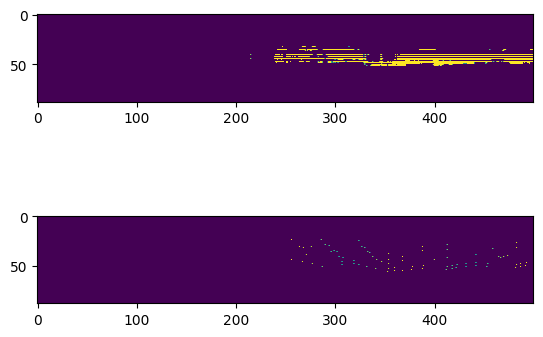

In [187]:
import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.imshow((score[0:500] > 0.05).squeeze().transpose(0, 1).cpu().detach().numpy())

plt.subplot(2, 1, 2)
plt.imshow(labels[0:500].transpose(0, 1).cpu().detach().numpy())

In [105]:
pasidx = 0
for i, (img, label) in enumerate(ds):
    if len(np.unique(label)) != 1:
        if pasidx != 50:
            pasidx+=1
        elif pasidx == 50:
            print(i)
            test_img, test_label = img, label
            break

474


In [106]:
ds[474][1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [107]:
out = model(ds[474][0].unsqueeze(dim=0).cuda())

In [108]:
out = nn.Softmax()(out)

/tmp/ipykernel_14678/3883280807.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.Softmax()(out)


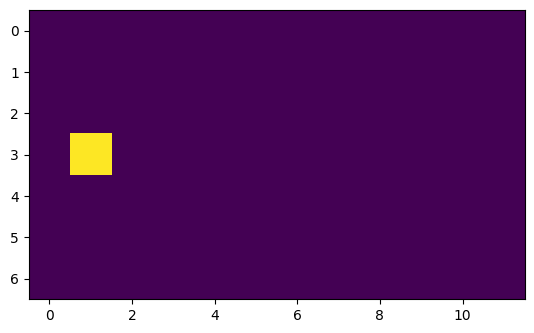

In [109]:
plt.imshow(ds[474][1][3:-1].reshape(-1, 12))

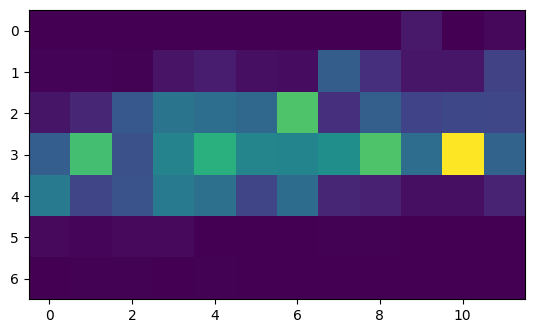

In [110]:
plt.imshow(out[0][3:-1].reshape(-1, 12).cpu().detach().numpy())

<Figure size 1000x5000 with 0 Axes>

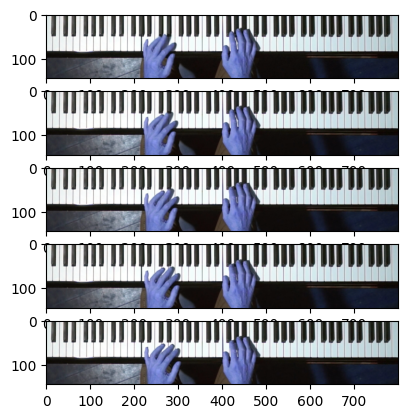

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 50))
fig, ax = plt.subplots(5, 1)
for i, img in enumerate(test_img):
    ax[i].imshow(img.permute(1, 2, 0))

------------------

## Midi experiment

In [6]:

"""
note : C0부터 0을 의미. 12 더할때마다 1 octave 증가
time : 앞의 note로부터 얼마나 지났는지를 보여줌
    ticks_per_beat, bpm으로 1초당 몇 tick인지 계산 가능(bpm 찾아야 할듯)
    time을 해당 tick으로 나누면 몇 초인지 계산가능
velocity : 누른 세기. 0이면 해당 note에서 손 뗌
tempo : 500,000us per tick. = 0.5s per tick
"""
import mido
from mido import MidiFile
from copy import deepcopy

mid = MidiFile('./data/PianoYT/pianoyt_MIDI/audio_100.0.midi')
# mid = MidiFile('./MIDItest/miditest_MIDI/5.mid')

In [7]:
bpm = mido.tempo2bpm(mid.tracks[0][0].tempo)
bps = bpm / 60.0

sec_per_tick = mid.ticks_per_beat * bps

In [8]:
# time을 이걸로 나누면 초 단위로 변경 가능
sec_per_tick

440.0

In [9]:
note_str = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

In [10]:
custom_notes = []
curtime = 0
for msg in mid.tracks[1]:
    if hasattr(msg, "note"):
        note_pitch = msg.note
        note_stat = "on" if msg.velocity > 0 else "off"
        curtime += msg.time
        note_time = curtime / sec_per_tick
        custom_notes.append({"status": note_stat, "note": note_pitch, "time(sec)":note_time})

In [11]:
def numeric_note_to_string(custom_note):
    custom_note_copy = deepcopy(custom_note)
    for note in custom_note_copy:
        note['note(str)'] = note_str[note['note'] % 12] + str(int(note['note']) // 12)
    return custom_note_copy

In [12]:
custom_notes = numeric_note_to_string(custom_notes)

In [ ]:
custom_notes

In [9]:
# midi drawing
curtime = 0
x = []
y = []
for msg in mid.tracks[1]:
    if hasattr(msg, "note"):
        if msg.velocity != 0:
            y.append(msg.note)
        curtime += msg.time
        if msg.velocity != 0:
            x.append(curtime)

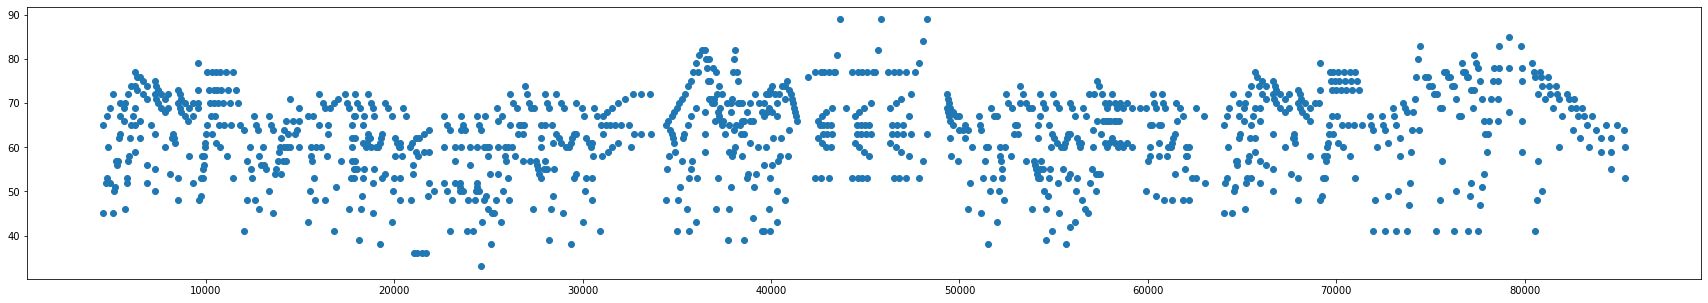

In [138]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 5))
plt.scatter(x, y)

## Midi to numpy

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
image_fps = 25
sec_per_frame = 1 / image_fps

In [13]:
notes_only_on = [note for note in custom_notes if note['status'] == 'on']

In [14]:
music_list = os.listdir("./images/train/")

for music in tqdm(music_list):
    frame_len = len(os.listdir(os.path.join("./images/train/", music)))
    music_idx = int(music.split("_")[0])
    label = np.zeros((frame_len, 88)) # top-down
    midi_idx = 0
    frame_time = 0.0
    
    mid = MidiFile(f'./PianoYT/pianoyt_MIDI/audio_{music_idx}.0.midi')
    
    bpm = mido.tempo2bpm(mid.tracks[0][0].tempo)
    bps = bpm / 60.0

    sec_per_tick = mid.ticks_per_beat * bps
    
    custom_notes = []
    curtime = 0
    for msg in mid.tracks[1]:
        if hasattr(msg, "note"):
            note_pitch = msg.note
            note_stat = "on" if msg.velocity > 0 else "off"
            curtime += msg.time
            note_time = curtime / sec_per_tick
            custom_notes.append({"status": note_stat, "note": note_pitch, "time(sec)":note_time})
            
    notes_only_on = [note for note in custom_notes if note['status'] == 'on']
    
    for i in range(frame_len):
        if midi_idx >= len(notes_only_on):
            break
        if notes_only_on[midi_idx]['time(sec)'] < frame_time:
            while midi_idx < len(notes_only_on) and notes_only_on[midi_idx]['time(sec)'] < frame_time:
                if notes_only_on[midi_idx]['note'] - 21 < 0:
                    print("minus")
                label[i][notes_only_on[midi_idx]['note'] - 21] = 1
                midi_idx += 1
        frame_time += sec_per_frame
        
    np.save(f"./labels/train/{music_idx}.npy", label)

FileNotFoundError: [Errno 2] No such file or directory: './images/train/'

In [78]:
label.shape

(5489, 88)

In [56]:
label_plot.shape

(88, 5489)

In [70]:
label[150:300].shape

(150, 88)

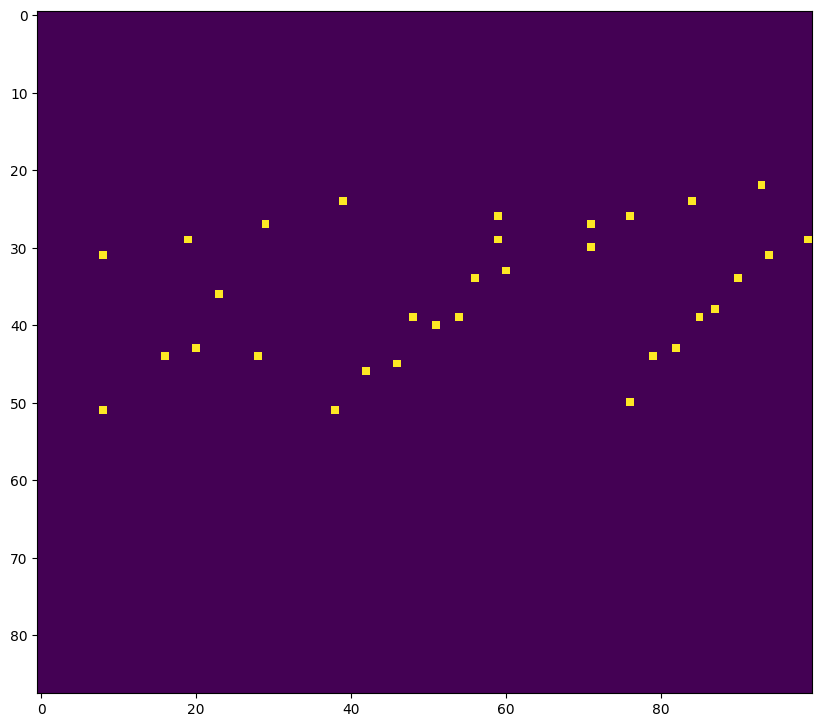

In [77]:
plt.figure(figsize=(10, 50))
plt.imshow(label[250:350].transpose()[::][::-1])

In [ ]:
custom_notes

-------------

## Video experiment

In [15]:
from pytube import YouTube

In [16]:
import pandas as pd
import cv2

In [17]:
from tqdm import tqdm

In [19]:
music_list = pd.read_csv('./data/PianoYT/pianoyt.csv', names=["index", "link", "train/test", "crop_minY", "crop_maxY", "crop_minX", "crop_maxX"])

In [20]:
music_list

,index,link,train/test,crop_minY,crop_maxY,crop_minX,crop_maxX
0,100,'https://www.youtube.com/watch?v=bAS4XoMwsWw',1,666,999,45,1874
1,101,'https://www.youtube.com/watch?v=hWJiTUs1EbU',1,663,1005,39,1867
2,102,'https://www.youtube.com/watch?v=u-fIxWQkQgQ',1,663,996,42,1869
3,103,'https://www.youtube.com/watch?v=u8kCm4hKa6g',1,676,991,44,1873
4,104,'https://www.youtube.com/watch?v=3cYMvB3rgzQ',1,662,996,43,1871
...,...,...,...,...,...,...,...
223,435,'https://www.youtube.com/watch?v=cvK-dRM9fL0',1,690,1140,4,1916
224,436,'https://www.youtube.com/watch?v=4G1tXBwvUNw',1,705,1176,11,1919
225,437,'https://www.youtube.com/watch?v=K6jn04Qb0J4',1,708,1152,17,1919
226,438,'https://www.youtube.com/watch?v=2nlvRLfHuzg',1,739,1136,99,1805


In [29]:
yt = YouTube(music_list.iloc[40]['link'])
yt.streams.filter(mime_type="video/mp4", res="1080p", progressive=False)

[<Stream: itag="137" mime_type="video/mp4" res="1080p" fps="25fps" vcodec="avc1.640028" progressive="False" type="video">]

In [30]:
for stream in yt.streams:
    print(stream)

<Stream: itag="17" mime_type="video/3gpp" res="144p" fps="6fps" vcodec="mp4v.20.3" acodec="mp4a.40.2" progressive="True" type="video">
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="25fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">
<Stream: itag="22" mime_type="video/mp4" res="720p" fps="25fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">
<Stream: itag="137" mime_type="video/mp4" res="1080p" fps="25fps" vcodec="avc1.640028" progressive="False" type="video">
<Stream: itag="248" mime_type="video/webm" res="1080p" fps="25fps" vcodec="vp9" progressive="False" type="video">
<Stream: itag="136" mime_type="video/mp4" res="720p" fps="25fps" vcodec="avc1.4d401f" progressive="False" type="video">
<Stream: itag="247" mime_type="video/webm" res="720p" fps="25fps" vcodec="vp9" progressive="False" type="video">
<Stream: itag="135" mime_type="video/mp4" res="480p" fps="25fps" vcodec="avc1.4d401e" progressive="False" type="video">
<St

In [119]:
# yt.streams로 사용 가능한 youtube 객체(동영상, 음성 등) 확인 가능
# filter로 원하는 형태의 stream 가져오기 가능
# video들은 25fps

os.makedirs("./videos/train/", exist_ok=True)
os.makedirs("./videos/test/", exist_ok=True)
for _, (is_train, music_link, music_idx) in tqdm(music_list[['train/test', 'link', 'index']].iterrows(), total=music_list.shape[0]):
    if is_train == 1:
        output_path = "./videos/train/"
    else:
        output_path = "./videos/test/"
    try:
        yt = YouTube(music_link)
        yt.streams.filter(mime_type="video/mp4", res="1080p").first().download(output_path=output_path, filename_prefix=f"{music_idx}_")
    except Exception:
        print(f"failed to download : {music_idx}, {music_link}")

 65%|██████▌   | 149/228 [46:46<38:41, 29.38s/it]  

failed to download : 259, 'https://www.youtube.com/watch?v=Y_QSVhy3zBY'


 84%|████████▍ | 191/228 [1:01:35<08:32, 13.85s/it]

failed to download : 400, 'https://www.youtube.com/watch?v=MBonQ6x7x_g'


 84%|████████▍ | 192/228 [1:01:38<06:16, 10.45s/it]

failed to download : 401, 'https://www.youtube.com/watch?v=O5WfUoXhnzk'


 85%|████████▍ | 193/228 [1:01:39<04:32,  7.79s/it]

failed to download : 402, 'https://www.youtube.com/watch?v=lh0juXMLUp0'


 85%|████████▌ | 194/228 [1:01:41<03:18,  5.84s/it]

failed to download : 403, 'https://www.youtube.com/watch?v=KkyXCyV4vxQ'


 86%|████████▌ | 195/228 [1:01:43<02:35,  4.72s/it]

failed to download : 404, 'https://www.youtube.com/watch?v=i8aIiHoYM0s'


 86%|████████▌ | 196/228 [1:01:45<02:04,  3.89s/it]

failed to download : 405, 'https://www.youtube.com/watch?v=6lVSwKTj6R4'


 86%|████████▋ | 197/228 [1:01:47<01:41,  3.29s/it]

failed to download : 406, 'https://www.youtube.com/watch?v=f3gmDIMAhhg'


 87%|████████▋ | 198/228 [1:01:48<01:26,  2.87s/it]

failed to download : 407, 'https://www.youtube.com/watch?v=zKiaKpsEPd0'


 87%|████████▋ | 199/228 [1:01:50<01:14,  2.58s/it]

failed to download : 408, 'https://www.youtube.com/watch?v=5bBT1aCfkKQ'


 88%|████████▊ | 200/228 [1:01:52<01:06,  2.36s/it]

failed to download : 409, 'https://www.youtube.com/watch?v=E4y0CZA1epQ'


 88%|████████▊ | 201/228 [1:01:53<00:55,  2.05s/it]

failed to download : 410, 'https://www.youtube.com/watch?v=lh0juXMLUp0'


 89%|████████▊ | 202/228 [1:01:56<00:57,  2.22s/it]

failed to download : 411, 'https://www.youtube.com/watch?v=5B9VwtPiEhg'


 91%|█████████ | 207/228 [1:02:44<02:36,  7.44s/it]

failed to download : 416, 'https://www.youtube.com/watch?v=ruzeujh-G60'


 91%|█████████ | 208/228 [1:02:46<01:55,  5.80s/it]

failed to download : 417, 'https://www.youtube.com/watch?v=r9KmxbzkkGo'


 92%|█████████▏| 209/228 [1:02:48<01:28,  4.64s/it]

failed to download : 418, 'https://www.youtube.com/watch?v=qAOCP6Zwtk4'


 92%|█████████▏| 210/228 [1:02:50<01:08,  3.81s/it]

failed to download : 419, 'https://www.youtube.com/watch?v=dyYs3H1u6nA'


 93%|█████████▎| 211/228 [1:02:52<00:58,  3.42s/it]

failed to download : 421, 'https://www.youtube.com/watch?v=CkMsPVOY3oo'


 93%|█████████▎| 212/228 [1:02:54<00:47,  2.98s/it]

failed to download : 422, 'https://www.youtube.com/watch?v=iRTm2dETa_Q'


 93%|█████████▎| 213/228 [1:02:56<00:40,  2.73s/it]

failed to download : 423, 'https://www.youtube.com/watch?v=iaHMLDIfrWQ'


 94%|█████████▍| 214/228 [1:02:58<00:34,  2.50s/it]

failed to download : 424, 'https://www.youtube.com/watch?v=73RJXTFlQQg'


 94%|█████████▍| 215/228 [1:03:00<00:30,  2.32s/it]

failed to download : 425, 'https://www.youtube.com/watch?v=S0ty10ARo94'


 95%|█████████▌| 217/228 [1:03:20<01:00,  5.49s/it]

failed to download : 427, 'https://www.youtube.com/watch?v=RNHsiA03PHI'


 96%|█████████▋| 220/228 [1:03:56<01:07,  8.45s/it]

failed to download : 430, 'https://www.youtube.com/watch?v=9CYUFeDazEM'


 98%|█████████▊| 223/228 [1:04:14<00:31,  6.24s/it]

failed to download : 434, 'https://www.youtube.com/watch?v=RvMBjzguZwk'


 98%|█████████▊| 224/228 [1:04:16<00:19,  4.97s/it]

failed to download : 435, 'https://www.youtube.com/watch?v=cvK-dRM9fL0'


 99%|█████████▊| 225/228 [1:04:19<00:12,  4.23s/it]

failed to download : 436, 'https://www.youtube.com/watch?v=4G1tXBwvUNw'


 99%|█████████▉| 226/228 [1:04:21<00:07,  3.54s/it]

failed to download : 437, 'https://www.youtube.com/watch?v=K6jn04Qb0J4'


100%|██████████| 228/228 [1:04:42<00:00, 17.03s/it]


In [7]:
import ffmpeg
import os

In [8]:
vid_list_train = sorted(os.listdir("./videos/train"))

In [ ]:
for vid_name in vid_list_train[:80]:
    idx = int(vid_name.split("_")[0])
    minY, maxY, minX, maxX = music_list[music_list['index']==idx][['crop_minY', 'crop_maxY', 'crop_minX', 'crop_maxX']].values[0]
    vid_path = os.path.join("./videos/train", vid_name)
    vid_obj = ffmpeg.input(vid_path)
    vid_save_path = f"images/train/{vid_name}"
    os.makedirs(vid_save_path, exist_ok=True)
    vid_obj.filter("fps", fps=25).filter("crop", maxX-minX, maxY-minY, minX, minY).filter("scale", "800", "145").output(os.path.join(vid_save_path, "%04d.png"), **{"qmin": 1, "qmax": 1}).run()

In [121]:
music_list.iloc[0]

index                                                   100
link          'https://www.youtube.com/watch?v=bAS4XoMwsWw'
train/test                                                1
crop_minY                                               666
crop_maxY                                               999
crop_minX                                                45
crop_maxX                                              1874
Name: 0, dtype: object

In [ ]:
test_vid.filter("fps", fps=25).filter("crop", "1829", "333", "45", "666").filter("scale", "800", "145").output("test/$filename%04d.png", **{"qmin": 5, "qmax": 5}).run()

In [87]:
cap = cv2.VideoCapture("./videos/100_Paul Rice “Waltz for Ella” FREE SHEET MUSIC P Barton FEURICH piano.mp4")

In [88]:
import matplotlib.pyplot as plt

In [89]:
frames = 0
while True:
    retval, frame = cap.read()
    cv2.imwrite(f"./test/out{frames}.png", frame)
    if retval:
        frames+=1
    if not(retval):	# 프레임정보를 정상적으로 읽지 못하면
        break  # while문을 빠져나가기
    break

In [198]:
frames

5488